### 加载数据

In [1]:
import pandas as pd

user_features = pd.read_csv('data/shopping/user_personalized_features.csv')
pd.set_option("display.max_columns", None)
user_features.head()

,Unnamed: 0,User_ID,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription
0,0,#1,56,Male,Suburban,38037,Sports,5,7,18,2546,Books,584,38,True
1,1,#2,46,Female,Rural,103986,Technology,15,7,118,320,Electronics,432,40,False
2,2,#3,32,Female,Suburban,101942,Sports,28,1,146,3766,Apparel,306,1,True
3,3,#4,60,Female,Suburban,71612,Fashion,18,3,163,4377,Apparel,527,29,False
4,4,#5,25,Male,Suburban,49725,Travel,2,5,141,4502,Health & Beauty,53,10,True


### 数据预处理

In [2]:
df =user_features.copy()
# 移除不需要的列
df = df.drop(['Unnamed: 0'], axis=1) 

# 将User_ID设为索引
df.set_index('User_ID', inplace=True)

### 特征工程
这一步将对数据进行一些处理，比如将一些非数值型的特征转换为数值型的特征，或者对一些数值型的特征进行归一化处理。

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 区分数值型和分类型特征
numerical_features = ['Age', 'Income', 'Last_Login_Days_Ago', 'Purchase_Frequency',
                     'Average_Order_Value', 'Total_Spending', 
                     'Time_Spent_on_Site_Minutes', 'Pages_Viewed']

categorical_features = ['Gender', 'Location', 'Interests', 'Product_Category_Preference']

# 特殊处理布尔型特征
df['Newsletter_Subscription'] = df['Newsletter_Subscription'].astype(int)

# 创建特征处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder( handle_unknown='ignore'), categorical_features)
    ])


### 特征转换

In [4]:
X = preprocessor.fit_transform(df)
print(f"\n转换后的特征矩阵形状: {X.shape}")

# 获取转换后的特征名称(用于后续可解释性)
numerical_feature_names = numerical_features
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_feature_names) + list(cat_feature_names)


转换后的特征矩阵形状: (1000, 23)


### 确定最佳K值

K=2, WCSS=9955.28, Silhouette Score=0.0718
K=3, WCSS=9460.98, Silhouette Score=0.0630
K=4, WCSS=9049.87, Silhouette Score=0.0641
K=5, WCSS=8716.63, Silhouette Score=0.0663
K=6, WCSS=8421.38, Silhouette Score=0.0687
K=7, WCSS=8183.38, Silhouette Score=0.0685
K=8, WCSS=7974.09, Silhouette Score=0.0675
K=9, WCSS=7795.79, Silhouette Score=0.0690
K=10, WCSS=7645.00, Silhouette Score=0.0689


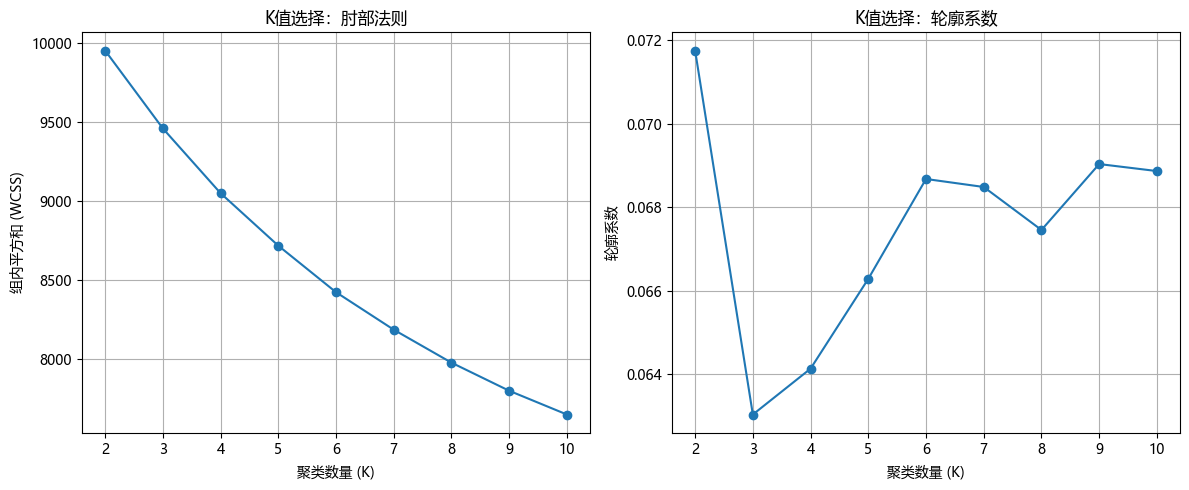

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
wcss = []
silhouette_scores = []
max_k = 10
min_k = 2

for k in range(min_k, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))
    print(f"K={k}, WCSS={kmeans.inertia_:.2f}, Silhouette Score={silhouette_score(X, labels):.4f}")

# 绘制肘部法则和轮廓系数图表
plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(min_k, max_k + 1), wcss, marker='o')
plt.title('K值选择：肘部法则')
plt.xlabel('聚类数量 (K)')
plt.ylabel('组内平方和 (WCSS)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(min_k, max_k + 1), silhouette_scores, marker='o')
plt.title('K值选择：轮廓系数')
plt.xlabel('聚类数量 (K)')
plt.ylabel('轮廓系数')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

### 应用K-means聚类

In [6]:
optimal_k =5 # 根据上面分析结果选择合适的K值
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X)

###  分析聚类结果


各用户群体的人数:
Cluster
0    191
1    197
2    199
3    205
4    208
Name: count, dtype: int64

各聚类数值特征均值:
               Age         Income  Last_Login_Days_Ago  Purchase_Frequency  \
Cluster                                                                      
0        52.575916   60915.984293            17.000000            6.350785   
1        34.157360  117268.751269            12.269036            6.659898   
2        27.366834   48715.206030            16.296482            5.005025   
3        40.756098   94472.297561            15.951220            2.087805   
4        50.067308   84166.769231            16.389423            3.278846   

         Average_Order_Value  Total_Spending  Time_Spent_on_Site_Minutes  \
Cluster                                                                    
0                 128.848168     3563.942408                  263.884817   
1                  90.233503     2609.751269                  330.588832   
2                  93.929648     2178.085427   

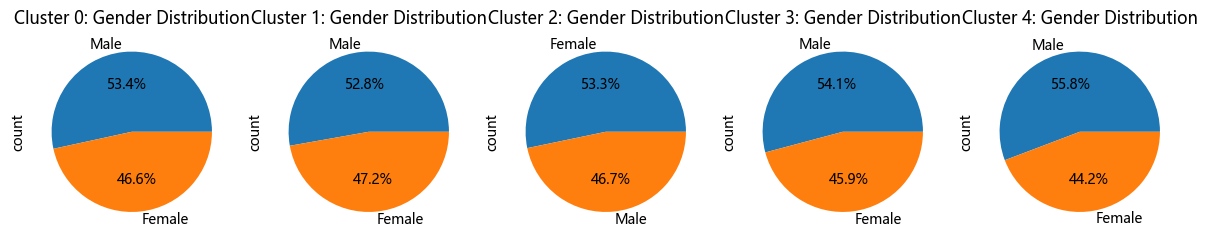

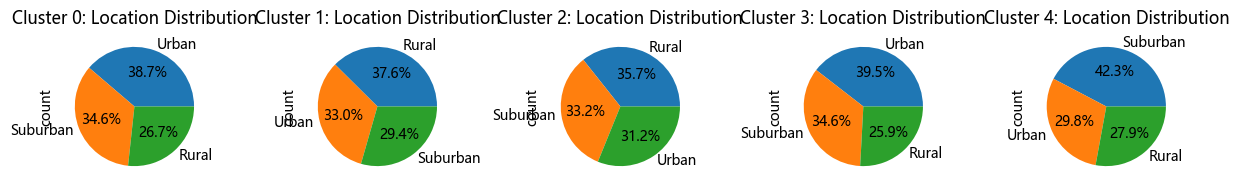

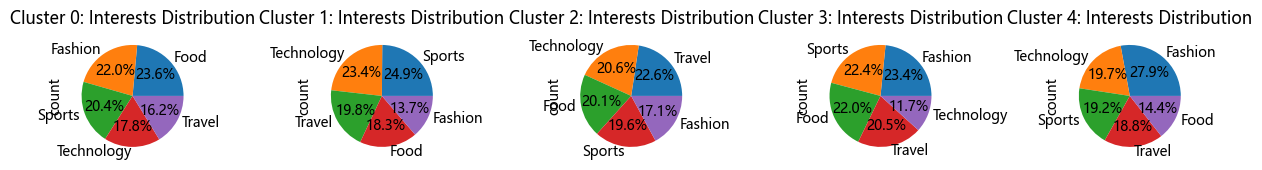

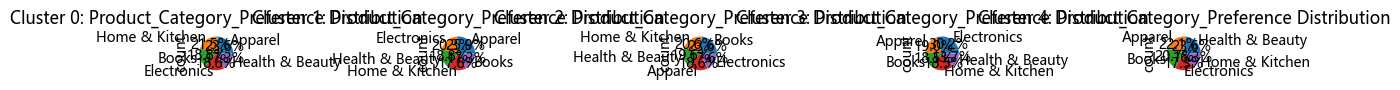

In [7]:
# 各聚类的人数统计
cluster_counts = df['Cluster'].value_counts().sort_index()
print("\n各用户群体的人数:")
print(cluster_counts)

cluster_stats_num = df.groupby('Cluster')[numerical_features].mean()
print("\n各聚类数值特征均值:")
print(cluster_stats_num)

# 分类特征分布
for cat_feature in categorical_features:
    plt.figure(figsize=(12, 6))
    for i in range(optimal_k):
        plt.subplot(1, optimal_k, i+1)
        df[df['Cluster'] == i][cat_feature].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Cluster {i}: {cat_feature} Distribution')
    plt.tight_layout()
    plt.show()
    plt.close()


### 可视化聚类结果 - 雷达图

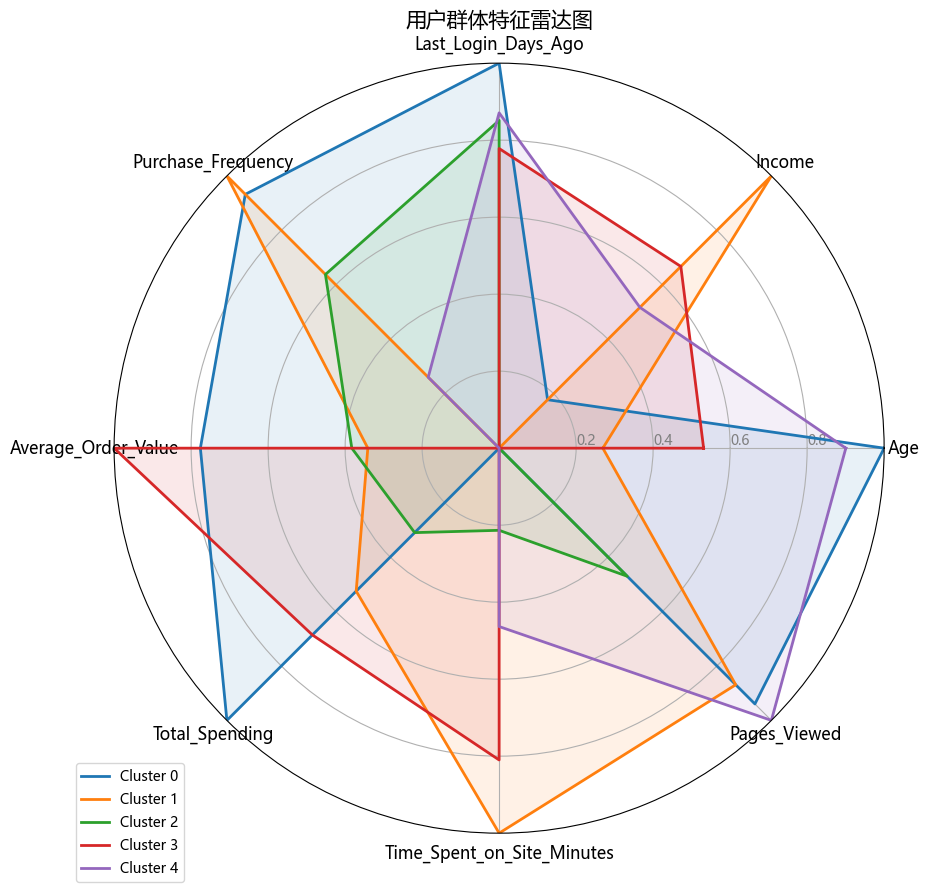

In [9]:
import numpy as np
# 标准化数据用于雷达图
radar_data = cluster_stats_num.copy()
for col in radar_data.columns:
    radar_data[col] = (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())

# 绘制雷达图
categories = numerical_features
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # 闭合雷达图

plt.figure(figsize=(12, 10))
ax = plt.subplot(111, polar=True)

for i in range(optimal_k):
    values = radar_data.iloc[i].tolist()
    values += values[:1]  # 闭合雷达图
    ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories, size=12)
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, 1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('用户群体特征雷达图', size=15)
plt.show()
plt.close()

In [10]:
# 根据聚类特征自动生成标签
def generate_cluster_label(cluster_stats, cluster_id):
    cluster_features = cluster_stats.iloc[cluster_id]
    
    # 判断购买力
    if cluster_features['Average_Order_Value'] > cluster_stats['Average_Order_Value'].median():
        spending = "高消费"
    else:
        spending = "低消费"
    
    # 判断活跃度
    if cluster_features['Purchase_Frequency'] > cluster_stats['Purchase_Frequency'].median():
        activity = "高活跃"
    else:
        activity = "低活跃"
    
    # 判断年龄段
    if cluster_features['Age'] < 35:
        age = "年轻"
    elif cluster_features['Age'] < 55:
        age = "中年"
    else:
        age = "年长"
    
    return f"{age}{activity}{spending}用户群体"

# 生成并应用标签
cluster_labels = {}
for i in range(optimal_k):
    cluster_labels[i] = generate_cluster_label(cluster_stats_num, i)

df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# 输出标签结果
print("\n用户群体标签:")
for cluster_id, label in cluster_labels.items():
    print(f"聚类 {cluster_id}: {label}")


用户群体标签:
聚类 0: 中年高活跃高消费用户群体
聚类 1: 年轻高活跃低消费用户群体
聚类 2: 年轻低活跃低消费用户群体
聚类 3: 中年低活跃高消费用户群体
聚类 4: 中年低活跃低消费用户群体
